### Get the data of the last two moths

In [30]:
# In the package's directory

from recommender_system import RedSQL, load_cfg
from mab import get_bandits_events
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
t1=time.time()

cfg = load_cfg()

In [3]:
with RedSQL(cfg['redshift']) as rs:
    data = get_bandits_events(rs)

t2=time.time()
print(t2-t1)

149.55895256996155


## a) Understand "compute_pulls"

In [4]:
from mab import compute_bandit_metrics, compute_pulls

In [5]:
pulls = compute_pulls(data)
metrics = compute_bandit_metrics(pulls)
metrics

{'version-v2.3.0': {'a': 4027.1198435562574, 'b': 95972.88015644375}}

In [6]:
# To distinguish the data, we use algorithm's tags
from mab.tag import TypeTag

In [10]:
pulls = compute_pulls(data, tag_extractor=TypeTag()) # By item
metrics = compute_bandit_metrics(pulls)
metrics

{'Planning': {'a': 3540.040367834144, 'b': 96459.95963216586},
 'Product': {'a': 5852, 'b': 86227},
 'EventPeople': {'a': 4190.055906161847, 'b': 95809.94409383814},
 'Exhibitor': {'a': 4377.619917364373, 'b': 95622.38008263563},
 'CommunityProfile': {'a': 0.01, 'b': 2353}}

In [11]:
# Click-through rate or probability of success (clearer) 
from mab.mab import ratios

ratios(metrics)

{'Planning': 0.03540040367834144,
 'Product': 0.0635541220039314,
 'EventPeople': 0.04190055906161848,
 'Exhibitor': 0.043776199173643726,
 'CommunityProfile': 4.249875691136034e-06}

## b) Modify "BanditStats"

In [7]:
# BanditStats (see Reference) is a class in mab.database to get the data from the database.
# It contains the parameter QUERY_DAYS and the method get_bandits_events

from datetime import datetime, timedelta
from recommender_system.database.templates import RSTemplate
from mab.filter import sanitize_filter

QUERY_DAYS = 15  # How far in the past we seek for data

In [8]:
class BanditStats(RSTemplate):
    query = """
    select type, user_id, platform, "time", properties from raw_tracking.v2 where type in ($types)
    and time between '$start' and '$end' order by time;
    """

    # Schema "raw_tracking", relation "v2"

def get_bandits_events(rs, query_days=None, now=None, keep_filter=None, no_similar=True, no_remove=True):
    if query_days is None:
        query_days = QUERY_DAYS
    if now is None:
        now = datetime.now()
    if keep_filter is None:
        keep_filter = sanitize_filter
    start = now - timedelta(days=query_days)
    carousel_type = "'recommendation_carousel_show'"
    items = ['person', 'planning', 'product', 'exhibitor']
    e_type = ['recommended'] if no_similar else ['recommended', 'similar']
    e_action = ['open'] if no_remove else ['open', 'remove']
    types = ', '.join([carousel_type] + [f"'{t}_{i}_{a}'" for t in e_type for i in items for a in e_action])
    # f-string for formatting; see https://realpython.com/python-f-strings/#:~:text=Also%20called%20formatted%20string%20literals,expressions%20with%20their%20resulting%20values.
    
    return [r for r in BanditStats.get(rs, start=start, end=now, types=types) if keep_filter(r)]

In [15]:
# Modified version of BanditStats that retrieves also the event_id 

from datetime import datetime, timedelta
from recommender_system.database.templates import RSTemplate
from mab.filter import sanitize_filter

QUERY_DAYS = 15
"""How far in the past we seek for data"""


class mod_BanditStats(RSTemplate):
    query = """
    select type, user_id, platform, "time", event_id, properties from raw_tracking.v2 where type in ($types)
    and time between '$start' and '$end' order by time;
    """
    #Aggiunto event_id

def mod_get_bandits_events(rs, query_days=None, now=None, keep_filter=None, no_similar=True, no_remove=True):
    if query_days is None:
        query_days = QUERY_DAYS
    if now is None:
        now = datetime.now()
    if keep_filter is None:
        keep_filter = sanitize_filter
    start = now - timedelta(days=query_days)
    carousel_type = "'recommendation_carousel_show'"
    items = ['person', 'planning', 'product', 'exhibitor']
    e_type = ['recommended'] if no_similar else ['recommended', 'similar']
    e_action = ['open'] if no_remove else ['open', 'remove']
    types = ', '.join([carousel_type] + [f"'{t}_{i}_{a}'" for t in e_type for i in items for a in e_action])
    return [r for r in mod_BanditStats.get(rs, start=start, end=now, types=types) if keep_filter(r)]

In [15]:
with RedSQL(cfg['redshift']) as rs:
    a=get_bandits_events(rs, no_similar=True, no_remove=True)
a

[{'type': 'recommendation_carousel_show',
  'user_id': 'VXNlcl8yMTkxNTI2Ng==',
  'platform': 'web-user',
  'time': datetime.datetime(2024, 11, 11, 17, 13, 50, 939496, tzinfo=datetime.timezone.utc),
  'properties': {'source': 'session_view',
   'metadata': '{"isColdStart":false,"version":"2.4.9"}',
   'is_initial': True,
   'event_view_id': 'RXZlbnRWaWV3Xzk4MTMyMg==',
   'visible_area_end': 0.5966,
   'visible_area_start': 0,
   'current_visible_ids': ['UGxhbm5pbmdfMjIyMTE5OQ==',
    'UGxhbm5pbmdfMjIyNTkwOQ==',
    'UGxhbm5pbmdfMjIyMTIxMw==']}},
 {'type': 'recommendation_carousel_show',
  'user_id': 'VXNlcl8yMjA3MzcyNQ==',
  'platform': 'web-user',
  'time': datetime.datetime(2024, 11, 11, 17, 13, 54, 552437, tzinfo=datetime.timezone.utc),
  'properties': {'source': 'attendee_view',
   'metadata': '{"isColdStart":true,"version":"2.4.9"}',
   'is_initial': True,
   'event_view_id': 'RXZlbnRWaWV3Xzk3MTI2NA==',
   'visible_area_end': 0.1384,
   'visible_area_start': 0,
   'current_visible_

In [16]:
with RedSQL(cfg['redshift']) as rs:
    b=mod_get_bandits_events(rs, no_similar=True, no_remove=True)
b

[{'type': 'recommendation_carousel_show',
  'user_id': 'VXNlcl8xMTk5NjU1OQ==',
  'platform': 'web-user',
  'time': datetime.datetime(2024, 11, 11, 17, 57, 38, 964486, tzinfo=datetime.timezone.utc),
  'event_id': 'RXZlbnRfMjA0MzIzNQ==',
  'properties': {'source': 'attendee_view',
   'metadata': '{"isColdStart":false,"version":"2.4.9"}',
   'is_initial': True,
   'event_view_id': 'RXZlbnRWaWV3XzkxMzE4MA==',
   'visible_area_end': 0.3826,
   'visible_area_start': 0,
   'current_visible_ids': ['RXZlbnRQZW9wbGVfMzM3NDA5ODI=',
    'RXZlbnRQZW9wbGVfMzM0OTA4NTQ=',
    'RXZlbnRQZW9wbGVfMzM3ODM4ODM=',
    'RXZlbnRQZW9wbGVfMzM1NjQzMzE=']}},
 {'type': 'recommendation_carousel_show',
  'user_id': 'VXNlcl8yMjA5NzkwNA==',
  'platform': 'web-user',
  'time': datetime.datetime(2024, 11, 11, 17, 57, 39, 184896, tzinfo=datetime.timezone.utc),
  'event_id': 'RXZlbnRfMTkwMjg2MA==',
  'properties': {'source': 'session_view',
   'metadata': '{"isColdStart":true,"version":"2.4.9"}',
   'is_initial': True,
   

### EXTRA: Learn Base64

In [24]:
from recommender_system.engagement.utils import kind64decode, kind64decode, b64decode, b64encode

In [18]:
kind64decode('VXNlcl8xNzkwNjU0Mg==' )

('User', 17906542)

In [19]:
kind64decode('RXZlbnRQZW9wbGVfMjgwMzI2NzE=')

('EventPeople', 28032671)

## c) Modify "compute_pulls" so it outputs a list of tuples (timestamp, event_id, success)

In [9]:
from collections import defaultdict
from datetime import timedelta

from mab.filter import is_carousel, r2t
from mab.tag import AlgoTag


TIME_OUT=600  # Seconds for a pull to be considered successful (grace period)

In [10]:
# Original version

def compute_pulls(data, tag_extractor=None, time_out=TIME_OUT, store_time=False):
    if tag_extractor is None:
        tag_extractor = AlgoTag()
    immediate = timedelta(seconds=0)
    time_out = timedelta(seconds=time_out)

    # opens associates to each action a list of times when it was performed
    actions = defaultdict(list)
    # Usually, a Python dictionary throws KeyError if you try to get an item with a key that is not present.
    # defaultdict in contrast creates any items that you try to access; in this case using list(), which returns a new empty list
    
    # carousels associates to each tag a list of pulls.
    # Each carousel pull is a tuple made of a list of potential actions and a time.
    carousels = defaultdict(list)
    for r in data:
        if is_carousel(r):
            tag = tag_extractor(r)
            if tag is None:
                continue
            carousels[tag].append((r2t(r), r['time']))
        else:
            actions[r2t(r)].append(r['time'])

    pulls = dict()
    for tag, carousel in carousels.items():
        pulls[tag] = {'success': list()}
        if store_time:
            pulls[tag]['time'] = list()
        for c in carousel:
            ok = False
            for tup in c[0]:
                if tup in actions:
                    for ti in actions[tup]:
                        if immediate <= ti - c[1] <= time_out:
                            ok = True
                            break
                    if ok:
                        break
            pulls[tag]['success'].append(ok)
            if store_time:
                pulls[tag]['time'].append(c[1])
    return pulls

In [23]:
# Modified version 

def mod_compute_pulls(data, tag_extractor=None, time_out=TIME_OUT, store_time=True):
#store_time so that it outputs the timestamp
    
    if tag_extractor is None:
        tag_extractor = AlgoTag()
    immediate = timedelta(seconds=0)
    time_out = timedelta(seconds=time_out)

    # opens associates to each action a list of times when it was performed
    actions = defaultdict(list)
    # carousels associates to each tag a list of pulls.
    # Each carousel pull is a tuple made of a list of potential actions and a time.
    carousels = defaultdict(list)
    for r in data:
        if is_carousel(r):
            tag = tag_extractor(r)
            if tag is None:
                continue
            carousels[tag].append((r2t(r), r['time']))
        else:
            actions[r2t(r)].append(r['time'])

    pulls = dict()
    for tag, carousel in carousels.items():
        pulls[tag] = {'success': list()}
        if store_time:
            pulls[tag]['time'] = list()
        for c in carousel:
            ok = False
            for tup in c[0]:
                if tup in actions:
                    for ti in actions[tup]:
                        if immediate <= ti - c[1] <= time_out:
                            ok = True
                            break
                    if ok:
                        break
            pulls[tag]['success'].append(ok)
            if store_time:
                pulls[tag]['time'].append(c[1])
                
        return [(pulls['version-v2.3.0']['time'][i],
                 # event_id MISSING... b[i]['event_id'] gives "list index out of range",
                 data[i]['event_id'],
                 pulls['version-v2.3.0']['success'][i]) for i in range(len(pulls['version-v2.3.0']['success']))]
    # Tuples of timestamp, event_id, success

In [24]:
with RedSQL(cfg['redshift']) as rs:
    mod_data = mod_get_bandits_events(rs)

mod_data

[{'type': 'recommendation_carousel_show',
  'user_id': 'VXNlcl8yMjA0NzE0MQ==',
  'platform': 'web-user',
  'time': datetime.datetime(2024, 11, 11, 17, 17, 36, 820373, tzinfo=datetime.timezone.utc),
  'event_id': 'RXZlbnRfMjAzMzc4OA==',
  'properties': {'source': 'attendee_view',
   'metadata': '{"isColdStart":false,"version":"2.4.9"}',
   'is_initial': True,
   'event_view_id': 'RXZlbnRWaWV3XzkwODg1OA==',
   'visible_area_end': 0.3826,
   'visible_area_start': 0,
   'current_visible_ids': ['RXZlbnRQZW9wbGVfMzM2ODMxMzI=',
    'RXZlbnRQZW9wbGVfMzM2ODI5OTI=',
    'RXZlbnRQZW9wbGVfMzQyODQxNzQ=',
    'RXZlbnRQZW9wbGVfMzQ2NTgzMDE=']}},
 {'type': 'recommendation_carousel_show',
  'user_id': 'VXNlcl8yMTc3ODAyNg==',
  'platform': 'web-user',
  'time': datetime.datetime(2024, 11, 11, 17, 17, 37, 134643, tzinfo=datetime.timezone.utc),
  'event_id': 'RXZlbnRfMjA5NDQzNQ==',
  'properties': {'source': 'session_view',
   'metadata': '{"isColdStart":true,"version":"2.4.9"}',
   'is_initial': False,
  

In [25]:
mod_pulls = mod_compute_pulls(mod_data)
mod_pulls

[(datetime.datetime(2024, 11, 11, 17, 17, 36, 820373, tzinfo=datetime.timezone.utc),
  'RXZlbnRfMjAzMzc4OA==',
  False),
 (datetime.datetime(2024, 11, 11, 17, 17, 37, 134643, tzinfo=datetime.timezone.utc),
  'RXZlbnRfMjA5NDQzNQ==',
  False),
 (datetime.datetime(2024, 11, 11, 17, 17, 37, 967592, tzinfo=datetime.timezone.utc),
  'RXZlbnRfMTkzNjE5MQ==',
  False),
 (datetime.datetime(2024, 11, 11, 17, 17, 38, 597825, tzinfo=datetime.timezone.utc),
  'RXZlbnRfMjA5NDQzNQ==',
  False),
 (datetime.datetime(2024, 11, 11, 17, 17, 40, 1257, tzinfo=datetime.timezone.utc),
  'RXZlbnRfMTc3MzY0Ng==',
  False),
 (datetime.datetime(2024, 11, 11, 17, 17, 40, 596092, tzinfo=datetime.timezone.utc),
  'RXZlbnRfMjA5NDQzNQ==',
  False),
 (datetime.datetime(2024, 11, 11, 17, 17, 42, 94010, tzinfo=datetime.timezone.utc),
  'RXZlbnRfMTkwMjg2MA==',
  False),
 (datetime.datetime(2024, 11, 11, 17, 17, 42, 107156, tzinfo=datetime.timezone.utc),
  'RXZlbnRfMTkyMDExMQ==',
  False),
 (datetime.datetime(2024, 11, 11, 1

## d) For all recent events: collect type, sector, category, time zone, and size

In [20]:
# For recent, we consider created >=2023 [Communities.get(rs, freshness=48)]
# All but size are in [raw_core.]core_event_v2 (events)
# For the size, we do a unique count on [raw_core.]core_event_profile

class info(RSTemplate):
    query = """
    SELECT id, type, sector, category, timezone
    FROM raw_core.core_event_v2_scd                                       
    WHERE created_at between '2024-01-01 00:00:00.000000' AND CURRENT_TIMESTAMP
    ORDER BY id;
    """

def collect_info(rs):
    return info.get(rs)

In [21]:
with RedSQL(cfg['redshift']) as rs:
    coll_data = collect_info(rs)
coll_data

[{'id': 1765467,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 {'id': 1765468,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 {'id': 1765508,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 {'id': 1765509,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 {'id': 1765558,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 {'id': 1765559,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 {'id': 1765571,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 {'id': 1765572,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 {'id': 1765584,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 {'id': 1765585,
  'type': '

In [28]:
[i['category'] for i in coll_data if i['category'] != None]

['CONFERENCE',
 'CONFERENCE',
 'EXHIBITION',
 'CORPORATE_EVENT',
 'OTHER',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFERENCE',
 'CONFEREN

In [29]:
# Size: UNIQUE (=distinct) COUNT in raw_core.core_event_profile (participants), i.e. number of participants per event 

class size(RSTemplate):
    query = """
    --Counting the number of distinct values in the 'prod' column 
    SELECT event_id, COUNT(*)
    
    --From the 'raw_core.core_event_profile' table
    FROM raw_core.core_event_profile

    WHERE created_at between '2024-01-01 00:00:00.000000' AND CURRENT_TIMESTAMP
    
    GROUP BY event_id
    
    ORDER BY event_id;
    """

def collect_size(rs):
    return size.get(rs)

In [30]:
with RedSQL(cfg['redshift']) as rs:
    size_data = collect_size(rs)
size_data

[{'event_id': 455, 'count': 1},
 {'event_id': 55617, 'count': 1},
 {'event_id': 73951, 'count': 4},
 {'event_id': 93032, 'count': 7},
 {'event_id': 93865, 'count': 1},
 {'event_id': 94176, 'count': 1},
 {'event_id': 95592, 'count': 2},
 {'event_id': 96660, 'count': 182},
 {'event_id': 103705, 'count': 1},
 {'event_id': 104274, 'count': 14},
 {'event_id': 104444, 'count': 821},
 {'event_id': 104885, 'count': 1},
 {'event_id': 104905, 'count': 1},
 {'event_id': 105249, 'count': 15},
 {'event_id': 107121, 'count': 8},
 {'event_id': 107261, 'count': 1},
 {'event_id': 108872, 'count': 33},
 {'event_id': 109666, 'count': 1},
 {'event_id': 110423, 'count': 18},
 {'event_id': 110908, 'count': 1},
 {'event_id': 110974, 'count': 16},
 {'event_id': 111224, 'count': 2},
 {'event_id': 111227, 'count': 2},
 {'event_id': 119437, 'count': 32},
 {'event_id': 120606, 'count': 27},
 {'event_id': 121712, 'count': 1},
 {'event_id': 122715, 'count': 571},
 {'event_id': 133488, 'count': 1},
 {'event_id': 133

In [31]:
# As a part has less events, we take the intersection

def add_size(L,l):
    for i in L:
        for j in l:
            if i['id']==j['event_id']:
                i['size'] = j['count'] 
    return L


result = add_size(coll_data, size_data)
result[:10]

[{'id': 1765467,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 140},
 {'id': 1765468,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 {'id': 1765508,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 140},
 {'id': 1765509,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 {'id': 1765558,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 139},
 {'id': 1765559,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 {'id': 1765571,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 139},
 {'id': 1765572,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 {'id': 1765584,
  'type

In [22]:
# Optimisation

# Pt1: By using comprehension get a dictionary
new_data ={d['id']:d for d in coll_data}
new_data

{1765467: {'id': 1765467,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 1765468: {'id': 1765468,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 1765508: {'id': 1765508,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 1765509: {'id': 1765509,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 1765558: {'id': 1765558,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 1765559: {'id': 1765559,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 1765571: {'id': 1765571,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 1765572: {'id': 1765572,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris'},
 1765584: {'id': 1765584,
  'type': 'PHYSICAL',
  'sector': None

In [33]:
for sdata in size_data:
    if sdata['event_id'] in new_data:
        new_data[sdata['event_id']]['size'] = sdata['count']
new_data

{1765467: {'id': 1765467,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 140},
 1765468: {'id': 1765468,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 1765508: {'id': 1765508,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 140},
 1765509: {'id': 1765509,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 1765558: {'id': 1765558,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 139},
 1765559: {'id': 1765559,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 1765571: {'id': 1765571,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 139},
 1765572: {'id': 1765572,
  'type': 'PHYSICAL',
  'sector': None,
  'category': No

In [34]:
new_data_list = [e for e in new_data.values()]
new_data_list

[{'id': 1765467,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 140},
 {'id': 1765468,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 {'id': 1765508,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 140},
 {'id': 1765509,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 {'id': 1765558,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 139},
 {'id': 1765559,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 {'id': 1765571,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 139},
 {'id': 1765572,
  'type': 'PHYSICAL',
  'sector': None,
  'category': None,
  'timezone': 'Europe/Paris',
  'size': 1},
 {'id': 1765584,
  'type

## e) Impact of the features on the click rate, i.e. quality (per-type and per-category)

In [11]:
def display_rates(rates, data_name='moving_avg', y_label='Click rate', pruning=400):
    fig, ax = plt.subplots(1, 1)
    for tag, stats in rates.items():
        rate = stats[data_name][::pruning]
        if 'time' in stats:
            ax.plot(stats['time'][::pruning], rate, label=tag)
        else:
            ax.plot(np.linspace(0, 1, len(rate)), rate, label=tag)
    plt.ylim([0, None])
    if 'time' in stats:
        plt.xlim([stats['time'][0], stats['time'][-1]])
        fig.autofmt_xdate()
        ax.xaxis.set_major_locator(WeekdayLocator())
        ax.xaxis.set_minor_locator(DayLocator())
    else:
        plt.xlim([0, 1])
    plt.ylabel(y_label)
    plt.xlabel('Time')
    if len(rates) > 1:
        plt.legend()
    ax.grid(True)
    plt.show()

# Moving average of binary success data to each tag's statistics in the input dictionary.
# Parameters rho (ecay rate ) and 1-rho that corresponds to having weights decreasing with geometric distribution. 
# Recent successes have a higher influence, and older successes gradually diminish in impact according to rho.


def geometric_average(pulls, size=1000):
    rho = 1/size
    for tag, stats in pulls.items():
        successes = stats['success']
        moving_avg = np.zeros(len(successes))                             # n-day moving average = average value in the last n-days period
        for i, s in enumerate(successes):
            moving_avg[i] = (1-rho) * moving_avg[i-1] + rho * int(s)
        pulls[tag]['moving_avg'] = moving_avg
        
# Modifies pulls (inplace)

In [12]:
# TIME: per type analysis
# Since I'll use event_dict for type, chategory, ..., size
# ... To be able to use the same geometric_average and display_rates, I define new tag extractors

from mab.tag import TagExtractor

class EventTypeExtractor(TagExtractor):
    """
    Tag by event type.
    """
    def __init__(self, event_dict):
        self.event_dict = event_dict
    def extract(self, r):
        return self.event_dict.get(kind64decode(r['event_id'])[1], {'type': '???'})['type']

In [25]:
pulls = compute_pulls(b, tag_extractor=EventTypeExtractor(event_dict=new_data), store_time=True)
pulls

{'???': {'success': [False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   True,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   

In [26]:
{k: len(v['success']) for k, v in pulls.items()}

{'???': 375242, 'HYBRID': 38023, 'VIRTUAL': 12882, 'PHYSICAL': 91583}

Click rate in time by type of event


NameError: name 'WeekdayLocator' is not defined

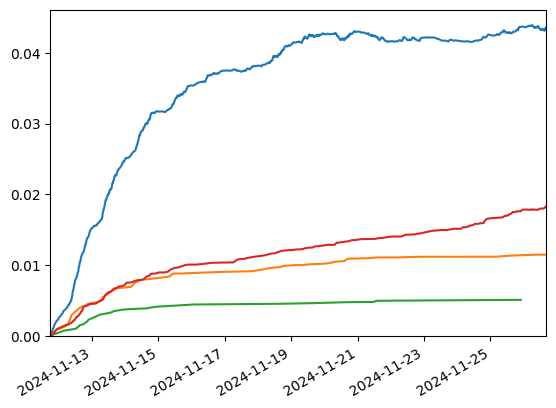

In [31]:
print('Click rate in time by type of event')
geometric_average(pulls, size=10**5)       
display_rates(pulls)

CTRs increase in time. 
Despite having the possibility to get to know products, other participants, etc. live at the event, users of pytical events are the ones clicking more. Similar for hybrid.
Almost no success for recommendations about virtual.

In [32]:
# TIME: per cathegory analysis

class EventCathegoryExtractor(TagExtractor):
    """
    Tag by event cathegory.
    """
    def __init__(self, event_dict):
        self.event_dict = event_dict
    def extract(self, r):
        return self.event_dict.get(kind64decode(r['event_id'])[1], {'category': '???'})['category']
        
# CATHERGORY: per item analysis

Click rate in time by category of event


NameError: name 'WeekdayLocator' is not defined

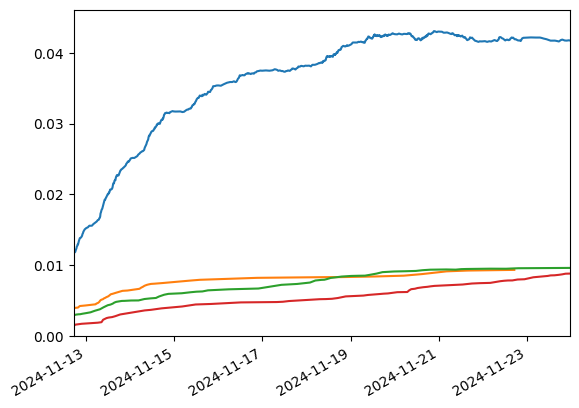

In [33]:
print('Click rate in time by category of event')
pulls = compute_pulls(b, tag_extractor=EventCathegoryExtractor(event_dict=new_data), store_time=True)
geometric_average(pulls, size=100000)        
display_rates(pulls)

The types of event with more clicks are conferences and exhibitions. Less clicks for 'other' and congresses. Almost no clicks for corporate events. 
No data in the last days for corporate events.

## f) Correlation between features




In [54]:
import pandas as pd
import seaborn as sns

In [55]:
df = pd.DataFrame.from_dict(new_data, orient='index')
df

,id,type,sector,category,timezone,size
1765467,1765467,PHYSICAL,None,None,Europe/Paris,140.0
1765468,1765468,PHYSICAL,None,None,Europe/Paris,1.0
1765508,1765508,PHYSICAL,None,None,Europe/Paris,140.0
1765509,1765509,PHYSICAL,None,None,Europe/Paris,1.0
1765558,1765558,PHYSICAL,None,None,Europe/Paris,139.0
...,...,...,...,...,...,...
1905797,1905797,PHYSICAL,None,None,Europe/Paris,1.0
1905822,1905822,HYBRID,HEALTHCARE,CONGRESS,Europe/Paris,240.0
1905846,1905846,PHYSICAL,None,None,Europe/Paris,108.0
1905848,1905848,PHYSICAL,None,None,Europe/Paris,1.0


In [56]:
df.duplicated().sum()

0

In [57]:
df.isnull().sum()

id             0
type           0
sector      5201
category    6177
timezone       0
size        2784
dtype: int64

In [58]:
# Average size of Swapcard events is ... participants, but the standard deviation is ...
df['size'].describe()

count     7826.000000
mean       287.557245
std       2360.263494
min          1.000000
25%          1.000000
50%          1.000000
75%        140.000000
max      74539.000000
Name: size, dtype: float64

Boxplot of size


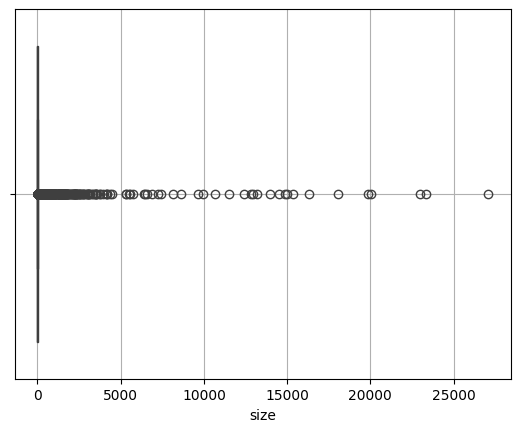

In [165]:
print('Boxplot of size')
sns.boxplot(x=df['size'])
plt.grid()

Size vs. type


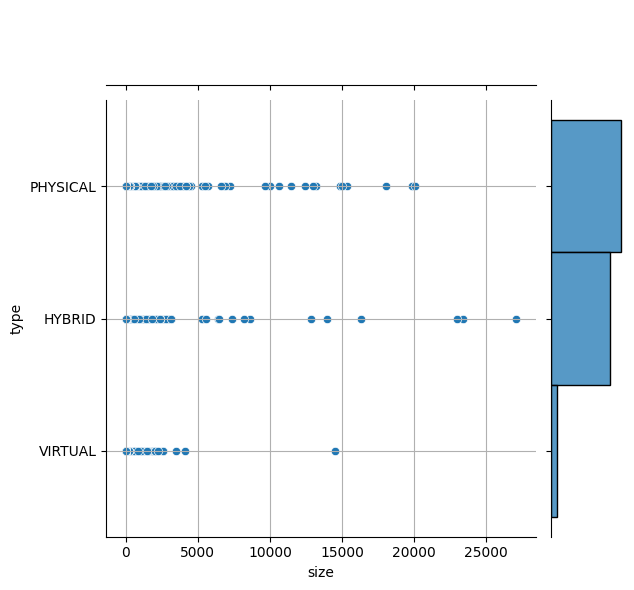

In [180]:
print('Size vs. type')
sns.jointplot(x='size', y='type', data=df)
plt.grid()
plt.show()

Physical modality was the most chosed. Physical events had in general less than 7500 partecipants, never more than 20.500 for space reasons. 
Hybrid modality suitable even for very big events.
Virtual events were very small: below 5000 partecipants. 

In [ ]:
print('Size vs. sector')
#plt.figure(figsize=(40,6))
sns.jointplot(x='size', y='sector', data=df)
plt.grid()
plt.show()

Swapcard's events are mostly in the technology sector and below 5000 participants.

In [ ]:
print('Size vs. category')
sns.jointplot(x='size', y='category', data=df)
plt.grid()
plt.show()

Swapcard's events mostly of category "other' (followed by conference and ehibition) and below 5000 participants.

In [ ]:
# Multiple dimentional data: size vs. click rate

In [186]:
df['category'].value_counts()

category
OTHER              5089
CONFERENCE          988
EXHIBITION          421
CONGRESS            106
CORPORATE_EVENT     100
Name: count, dtype: int64

In [62]:
# Sample data
values_a = df['size']
pulls = compute_pulls(b, tag_extractor=EventSizeExtractor(event_dict=new_data))

print(values_a)

1765467    140.0
1765468      1.0
1765508    140.0
1765509      1.0
1765558    139.0
           ...  
1950153      1.0
1950607      1.0
1950669      1.0
1950691      1.0
1950696      1.0
Name: size, Length: 13990, dtype: float64


In [78]:
# List comprehension to get 'size' or default to 0
sizes = [event.get('size', 0) for event in new_data.values()]
sizes

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 6,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [ ]:
from collections import Counter

event_stats = Counter((kind64decode(r[1])[1], r[2]) for r in mod_pulls)
event_stats

In [26]:
cr = dict()
for event_value in event_stats:
    e = event_value[0]
    if e not in cr:
        trues = event_stats.get((e, True), 0)
        falses = event_stats.get((e, False), 0)
        cr[e] = trues/(trues+falses)                             # successes / total

cr

{1529889: 0.05190311418685121,
 1774837: 0.04286185295087372,
 1856210: 0.1125,
 1849574: 0.051787916152897656,
 1695954: 0.04405043775122515,
 1062438: 0.0,
 1794810: 0.04109994086339444,
 1410138: 0.04234527687296417,
 1914830: 0.042922707833524566,
 1905035: 0.04531174480425326,
 1862523: 0.04596191726854892,
 1792779: 0.018867924528301886,
 1856278: 0.04776119402985075,
 1679763: 0.05182648401826484,
 1104656: 0.02040816326530612,
 1888546: 0.04527027027027027,
 1851396: 0.04812319538017324,
 1867527: 0.044586394123283295,
 1742419: 0.026785714285714284,
 1711383: 0.045847750865051905,
 1846397: 0.048,
 1743920: 0.05517241379310345,
 1923319: 0.05580215599239061,
 1493068: 0.04987646695491044,
 1726703: 0.051432291666666664,
 1867785: 0.04805739813185326,
 1774696: 0.051818634778276036,
 1739746: 0.030927835051546393,
 1728371: 0.04480678730032478,
 1906528: 0.023346303501945526,
 1784880: 0.053208137715179966,
 1747637: 0.0481283422459893,
 1801922: 0.06542056074766354,
 1786043: 

In [27]:
size={event['id']: event.get('size', 0) for event in new_data.values()}
size

{1765467: 140,
 1765468: 1,
 1765508: 140,
 1765509: 1,
 1765558: 139,
 1765559: 1,
 1765571: 139,
 1765572: 1,
 1765584: 129,
 1765585: 1,
 1765623: 140,
 1765624: 1,
 1765637: 140,
 1765638: 1,
 1765653: 140,
 1765654: 1,
 1765666: 140,
 1765667: 1,
 1765679: 140,
 1765680: 1,
 1765692: 140,
 1765693: 1,
 1765731: 140,
 1765732: 140,
 1765733: 1,
 1765734: 1,
 1765757: 1,
 1765759: 140,
 1765760: 1,
 1765776: 224,
 1765780: 139,
 1765781: 1,
 1765794: 1,
 1765823: 138,
 1765824: 1,
 1765865: 140,
 1765866: 1,
 1765878: 178,
 1765879: 140,
 1765880: 1,
 1765881: 2,
 1765894: 140,
 1765895: 1,
 1765910: 140,
 1765911: 1,
 1765939: 140,
 1765940: 1,
 1765964: 140,
 1765965: 1,
 1766016: 140,
 1766017: 1,
 1766031: 1811,
 1766035: 140,
 1766036: 1,
 1766051: 136,
 1766052: 1,
 1766064: 1,
 1766066: 140,
 1766067: 1,
 1766081: 140,
 1766082: 1,
 1766131: 140,
 1766132: 1,
 1766144: 140,
 1766145: 1,
 1766179: 139,
 1766180: 1,
 1766190: 1,
 1766201: 140,
 1766202: 1,
 1766214: 140,
 17662

In [28]:
def populate_data_dict(dict1, dict2):
    data_dict={}
    for k in dict1.keys():
        if k in dict2.keys():
            data_dict[k]=(dict1[k], dict2[k])
    return data_dict
            
data_dict=populate_data_dict(cr, size)       #event_id: (clickrate, size)}
data_dict

{1774837: (0.04286185295087372, 3312),
 1856210: (0.1125, 2226),
 1849574: (0.051787916152897656, 1355),
 1794810: (0.04109994086339444, 709),
 1905035: (0.04531174480425326, 3066),
 1862523: (0.04596191726854892, 903),
 1792779: (0.018867924528301886, 762),
 1856278: (0.04776119402985075, 1568),
 1888546: (0.04527027027027027, 296),
 1851396: (0.04812319538017324, 10653),
 1867527: (0.044586394123283295, 1687),
 1846397: (0.048, 432),
 1867785: (0.04805739813185326, 31450),
 1774696: (0.051818634778276036, 2981),
 1784880: (0.053208137715179966, 252),
 1801922: (0.06542056074766354, 1223),
 1786043: (0.04762078661943542, 4297),
 1772425: (0.045028630921395106, 2272),
 1775015: (0.043123162365240116, 1580),
 1859806: (0.031914893617021274, 541),
 1791300: (0.07894736842105263, 376),
 1839235: (0.047493403693931395, 503),
 1767936: (0.04423979776092452, 23356),
 1790251: (0.014084507042253521, 5298),
 1790667: (0.0511200459506031, 13194),
 1877167: (0.09523809523809523, 129),
 1798670: 

In [29]:
cr_vector = [i[0] for i in data_dict.values()]       # vectors of click rates
size_vector = [i[1] for i in data_dict.values()]     # vectors of sizes

In [31]:
cr_key_list=list(cr.keys())
cr_key_list.sort()
sorted_cr = {i : cr[i] for i in cr_key_list if i in size.keys()}
sorted_cr

{1765878: 0.0,
 1766349: 0.0,
 1766665: 0.0,
 1767091: 0.07936507936507936,
 1767184: 0.16666666666666666,
 1767936: 0.04423979776092452,
 1768108: 0.0,
 1768268: 0.0,
 1768536: 0.0,
 1769080: 0.03468208092485549,
 1769205: 0.0,
 1769722: 0.0,
 1770410: 0.0,
 1771813: 0.0,
 1772399: 0.0,
 1772425: 0.045028630921395106,
 1772428: 0.0334313005143277,
 1773116: 0.05898876404494382,
 1773411: 0.08333333333333333,
 1773416: 0.045454545454545456,
 1773460: 0.02564102564102564,
 1773612: 0.0,
 1773646: 0.0,
 1773679: 0.0,
 1773682: 0.0,
 1773696: 0.061224489795918366,
 1774119: 0.052132701421800945,
 1774659: 0.05357142857142857,
 1774664: 0.04355165428764349,
 1774686: 0.0,
 1774696: 0.051818634778276036,
 1774720: 0.03849443969204448,
 1774800: 0.07920792079207921,
 1774837: 0.04286185295087372,
 1774847: 0.0,
 1774901: 0.043233082706766915,
 1775015: 0.043123162365240116,
 1775019: 0.0,
 1775163: 0.5,
 1775792: 0.04054054054054054,
 1775794: 0.06451612903225806,
 1775837: 0.061224489795918

In [32]:
df['click rate'] = pd.DataFrame.from_dict(sorted_cr, orient='index')
df

,id,type,sector,category,timezone,size,click rate
1765467,1765467,PHYSICAL,None,None,Europe/Paris,140.0,NaN
1765468,1765468,PHYSICAL,None,None,Europe/Paris,1.0,NaN
1765508,1765508,PHYSICAL,None,None,Europe/Paris,140.0,NaN
1765509,1765509,PHYSICAL,None,None,Europe/Paris,1.0,NaN
1765558,1765558,PHYSICAL,None,None,Europe/Paris,139.0,NaN
...,...,...,...,...,...,...,...
1905797,1905797,PHYSICAL,None,None,Europe/Paris,1.0,NaN
1905822,1905822,HYBRID,HEALTHCARE,CONGRESS,Europe/Paris,1.0,NaN
1905846,1905846,PHYSICAL,None,None,Europe/Paris,108.0,NaN
1905848,1905848,PHYSICAL,None,None,Europe/Paris,1.0,NaN


In [ ]:
df.to_csv(r"C:\Users\Bonazza Arianna\Desktop\df.csv")

In [40]:
# Discarding events with 0 cr or size
no0df = df[(df[['size','click rate']] != 0).all(axis=1)]
no0df

,id,type,sector,category,timezone,size,click rate
1766031,1766031,VIRTUAL,TECHNOLOGY,None,America/New_York,1811.0,NaN
1766035,1766035,PHYSICAL,None,None,Europe/Paris,140.0,NaN
1766036,1766036,PHYSICAL,None,None,Europe/Paris,1.0,NaN
1766051,1766051,PHYSICAL,None,None,Europe/Paris,136.0,NaN
1766052,1766052,PHYSICAL,None,None,Europe/Paris,1.0,NaN
...,...,...,...,...,...,...,...
1905797,1905797,PHYSICAL,None,None,Europe/Paris,1.0,NaN
1905822,1905822,HYBRID,HEALTHCARE,CONGRESS,Europe/Paris,1.0,NaN
1905846,1905846,PHYSICAL,None,None,Europe/Paris,108.0,NaN
1905848,1905848,PHYSICAL,None,None,Europe/Paris,1.0,NaN


Size vs. click rate


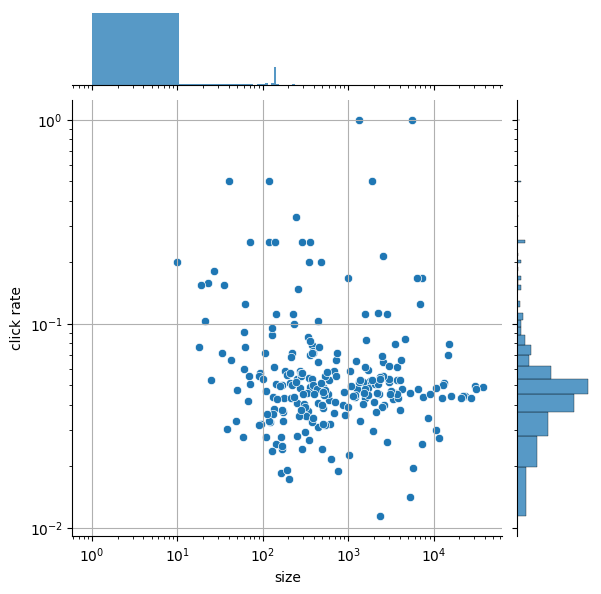

In [37]:
# Loglog plot

print('Size vs. click rate')
#plt.figure(figsize=(40,6))
sns.jointplot(x='size', y='click rate', data=no0df)
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.show()

In [26]:
# Discarding events with NaN cr or size
no0noNaNdf=no0df.dropna(subset=['click rate'])
no0noNaNdf=no0noNaNdf.dropna(subset=['size'])
no0noNaNdf

,Unnamed: 0,id,type,sector,category,timezone,size,click rate
144,1767091,1767091,VIRTUAL,OTHER,CONFERENCE,Europe/London,3499.0,0.079365
150,1767184,1767184,HYBRID,TECHNOLOGY,CONFERENCE,America/New_York,7404.0,0.166667
219,1767936,1767936,HYBRID,NaN,NaN,Europe/Paris,23356.0,0.044240
309,1769080,1769080,PHYSICAL,NaN,NaN,Europe/Berlin,351.0,0.034682
639,1772425,1772425,HYBRID,NaN,CONFERENCE,America/New_York,2272.0,0.045029
...,...,...,...,...,...,...,...,...
10397,1904681,1904681,PHYSICAL,HEALTHCARE,CONGRESS,Europe/Paris,211.0,0.057303
10408,1904896,1904896,PHYSICAL,NaN,NaN,Europe/Paris,108.0,0.027933
10423,1905035,1905035,PHYSICAL,SHIPPING,CONFERENCE,America/New_York,3066.0,0.045312
10458,1905612,1905612,PHYSICAL,MANUFACTURING,CONFERENCE,Etc/GMT+4,112.0,0.035971


Size vs. click rate


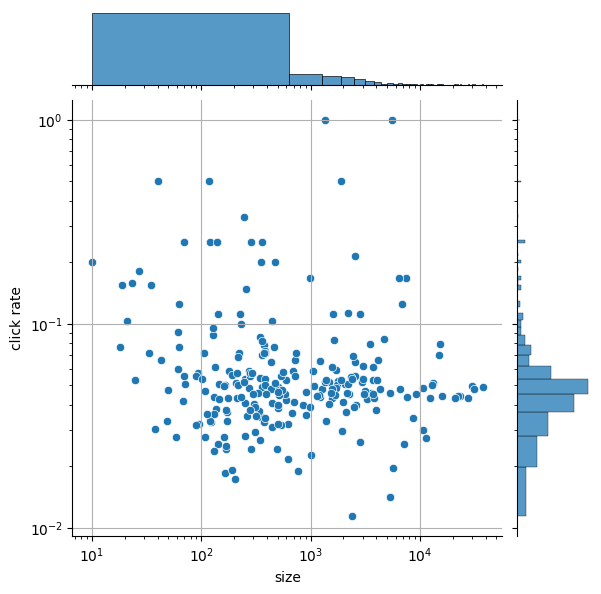

In [31]:
print('Size vs. click rate')
#plt.figure(figsize=(40,6))
sns.jointplot(x='size', y='click rate', data=no0noNaNdf)
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.show()

<Axes: >

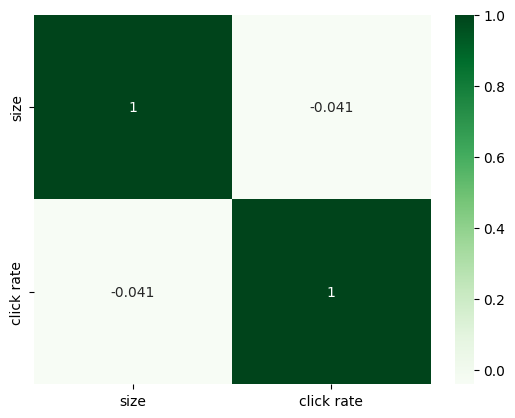

In [36]:
# Correlation matrix - Heatmap

dataframe= no0noNaNdf[['size', 'click rate']]
matrix = dataframe.corr()
sns.heatmap(matrix, cmap="Greens", annot=True)

Click rate and size slightly negatively correlated (-0.041). We find out that in big events attendees are less interested in networking, so it's less likely that they click on recommendations.

Nonetheless, as said above, for many events the cr is NaN (i.e. can't be calculated).
Doing the math we find out that hence we just considered 2.3% of the events (the ones with rational and not null size and cr).
Opening the database (to find a pattern) we find out that a lot of recommendations have event_id "null". The reason of this should be investigated.